# EX10. 프로젝트 - 뉴스기사 요약해보기 

새로운 데이터셋에 대해서 추상적 요약과 추출적 요약해보기!

## -목차-    

### Step 1. 데이터 수집하기     
### Step 2. 데이터 전처리하기 (추상적 요약)    
### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)   
### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)    
### Step 5. Summa을 이용해서 추출적 요약해보기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print('❤️')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


❤️


# Step 1. 데이터 수집하기    
[sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)에서 news_summary_more.csv사용   
추출적 요약을 하는 경우에는 오직 text열만을 사용하기

In [58]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [60]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [59]:
data.sample(10)

,headlines,text
78646,Sunny's past has no bearing on how she'll be a...,Actor Ram Kapoor has said that the career choi...
95478,Kerala BJP candidate promises good beef supply...,BJP candidate for the upcoming by-election in ...
39338,No Twitter after yoga: Rhodes on replying to f...,After replying to a fake Sunil Chhetri Twitter...
44917,Sri Lanka win a T20I vs India for first time a...,Sri Lanka registered their first T20I victory ...
18298,Cook departs for 71 in 1st innings of his care...,Former England captain Alastair Cook got dismi...
51310,Taliban claims Afghanistan hotel attack that k...,The Taliban has claimed responsibility for the...
53876,Don't make a joke out of the country: Pak SC s...,Expressing dissatisfaction over the performanc...
10044,BJP obstructing name change of West Bengal to ...,"Attacking the BJP-led Centre, West Bengal CM M..."
96194,Trump signs order to roll back Obama-era clima...,The US President Donald Trump on Tuesday signe...
69646,London-bound BA flight evacuated over 'direct ...,A London-bound British Airways flight was evac...


# Step 2. 데이터 전처리하기(추상적 요약)

## 2-1. 데이터 정리하기

In [64]:
#중복 샘플 유무 확인
print('전체 샘플수 :', (len(data)))
print('중복을 배제한 유일한 headlines 샘플의 수 :', data['headlines'].nunique())
print('중복을 배제한 유일한 text 샘플의 수 :', data['text'].nunique())

전체 샘플수 : 98401
중복을 배제한 유일한 headlines 샘플의 수 : 98280
중복을 배제한 유일한 text 샘플의 수 : 98360


####  중복데이터 처리   
   - drop_duplicates : 중복 요소 삭제    

   - subset : 중복데이터를 처리할 열 입력받음    

   - inplace : 메서드가 적용되는 원본 데이터를 변경할지 여부 결정

In [66]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꾼다.
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))
print('unique한 headline 수: ', data['headlines'].nunique())

전체 샘플수 : 98360
unique한 headline 수:  98262


### null값 확인!! - 없는 것을 확인 할 수 있음

In [67]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 텍스트 정규화와 불용어 제거하기  

* 텍스트 정규화 : 예를들어 mustn't과 must not은 같은 표현이므로 이런 경우들을 기계학습 전에 미리 같은표현으로 통일시켜주기  
(기계의 연산량을 줄이기위해!!)

[정규화 사전 출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [68]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


* 불용어(stopwords) 제거   

\- 일반적인 텍스트에는 자주 등장하지만 자연어 처리를 할 때는 실질적으로 도움이 되지 않는 단어를 불용어라고 함

In [69]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [70]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # text 전처리 시에만 호출하고 상대적을 문장길이가 짧은 summary전처리 할 때는 호출하지 않음
    # abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 불용어들이 summary에는 남아 있는 것이 더 좋을 것 같아서
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [71]:
clean_text = []

# 전체 Text 데이터에 대한 전처리  
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [72]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [73]:
# 쉽게 확인하기 위해서 데이터들을 데이터프레임에 재 저장하기
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [74]:
# isnull().sum()을 사용해서 null값이 생겼는지 확인
data.isnull().sum()

headlines    0
text         0
Text         0
Summary      0
dtype: int64

In [75]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98360


### 데이터의 최대길이 정하는 단계
\- Text와 headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 보기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 18
헤드라인의 평균 길이 : 9.553660024400163


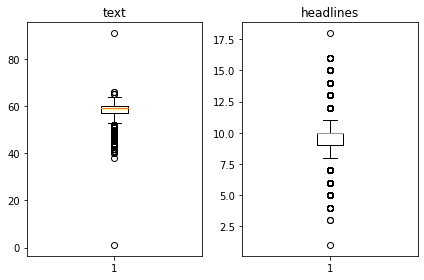

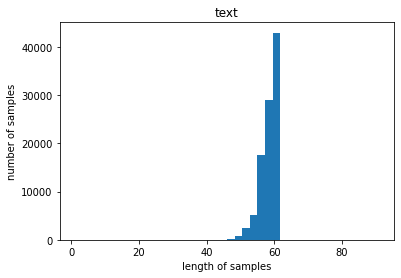

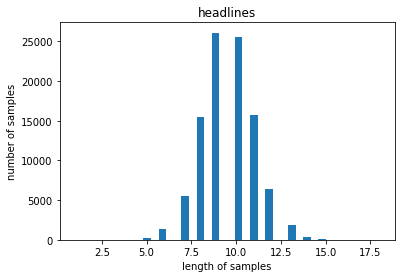

In [76]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headline_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headline_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1, 2, 1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1, 2, 2)
plt.boxplot(headline_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

text 그래프를 보면 대략적으로 45~60사이의 데이터가 많음 - 65이하로 잘라주기     

headlines 그래프는 대략 13으로 잘라주면 될 것 같음

In [77]:
text_max_len = 62
headline_max_len = 13

In [78]:
# max_len을 합리적으로 해줬는지 확인해보기
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt+1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt/len(nested_list))))

In [79]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len, data['headlines'])

전체 샘플 중 길이가 62 이하인 샘플의 비율: 0.9997153314355429
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9957706384709232


In [80]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플 수:', len(data))

전체 샘플 수: 97916


### 시작 토큰과 종료 토큰 추가하기    
시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가

In [81]:
data['decoder_input']=data['headlines'].apply(lambda x:'sostoken '+x)
data['decoder_target']=data['headlines'].apply(lambda x:x+' eostoken')
data.head()

,headlines,text,Text,Summary,decoder_input,decoder_target
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upGrad learner switches to career in ...,upGrad learner switches to career in ML & Al w...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...,"sostoken Have known Hirani for yrs, what if Me...","Have known Hirani for yrs, what if MeToo claim..."


In [82]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [83]:
# 훈련데이터와 테스트 데이터 분리
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[17020 68874 17989 ... 33196 75786 20555]


In [84]:
# 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

### 전체 데이터 훈련, 테스트 데이터로 나누기

In [85]:
# 이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
# 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19583


In [86]:
# 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분하기
# :표시의 위치에 주의
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78333
훈련 레이블의 개수 : 78333
테스트 데이터의 개수 : 19583
테스트 레이블의 개수 : 19583


### 단어 집합(vocabulary) 만들기 및 정수 인코딩 
\- 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 함

In [87]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성 

In [88]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69480
등장 빈도가 6번 이하인 희귀 단어의 수: 47392
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22088
단어 집합에서 희귀 단어의 비율: 68.20955670696604
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.499596986565249


In [89]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합 크기에 제한을 둔다.
src_tokenizer.fit_on_texts(encoder_input_train)

In [90]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))

[[274, 3088, 5430, 3904, 1, 130, 265, 2469, 694, 13, 1469, 13761, 13338, 17454, 694, 1012, 3904, 2783, 620, 2784, 203, 91, 1840, 152, 2563, 275, 44, 281, 3904, 1896, 13338, 694, 1012], [150, 237, 793, 5, 12182, 417, 890, 19440, 235, 12938, 5984, 3878, 10724, 150, 237, 1, 1235, 4117, 6456, 1283, 890, 124, 4876, 1007, 387, 150, 237, 1, 18381], [50, 1254, 144, 180, 566, 996, 82, 2933, 144, 1, 1072, 26, 265, 4244, 180, 2933, 1008, 558, 14, 6782, 1254, 1, 2933, 1447, 83, 105, 2769, 816, 22, 3808, 834, 11856]]
훈련 데이터의 개수 : 78333
훈련 레이블의 개수 : 78333


#### headlines 데이터 정수 시퀀스로 변환하기

In [91]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train) 
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78333
훈련 레이블의 개수 : 78333
테스트 데이터의 개수 : 19583
테스트 레이블의 개수 : 19583


In [93]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40683
등장 빈도가 6번 이하인 희귀 단어의 수: 30421
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10262
단어 집합에서 희귀 단어의 비율: 74.7757048398594
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.906530462126489


In [94]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2879, 3, 433, 4, 6, 18, 8152], [1, 14, 35, 73, 467, 534, 80, 422, 266, 132], [1, 1700, 20, 1138, 58, 3, 712, 55, 6, 4585, 745], [1, 2622, 1979, 4, 506, 84, 604, 130, 7, 1809, 41], [1, 841, 3, 263, 164, 3149, 6183, 306, 2767, 33, 126, 3, 2623]]
target
decoder  [[2879, 3, 433, 4, 6, 18, 8152, 2], [14, 35, 73, 467, 534, 80, 422, 266, 132, 2], [1700, 20, 1138, 58, 3, 712, 55, 6, 4585, 745, 2], [2622, 1979, 4, 506, 84, 604, 130, 7, 1809, 41, 2], [841, 3, 263, 164, 3149, 6183, 306, 2767, 33, 126, 3, 2623, 2]]


In [95]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 78333
훈련 레이블의 개수 : 78333
테스트 데이터의 개수 : 19582
테스트 레이블의 개수 : 19582


### 패딩하기   
\- 정한 최대 길이 기준으로 패딩하기

In [96]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## 모델 설계하기

In [97]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [98]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

# Step 3. 어텐션 메커니즘 사용하기(추상적 요약)

In [99]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [100]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 62)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 62, 128)      2560000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 62, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [101]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
306/306 [==============================] - 249s 779ms/step - loss: 6.8884 - val_loss: 6.1954
Epoch 2/50
306/306 [==============================] - 247s 806ms/step - loss: 6.1226 - val_loss: 5.8550
Epoch 3/50
306/306 [==============================] - 250s 816ms/step - loss: 5.7365 - val_loss: 5.5203
Epoch 4/50
306/306 [==============================] - 248s 811ms/step - loss: 5.4045 - val_loss: 5.3087
Epoch 5/50
306/306 [==============================] - 249s 814ms/step - loss: 5.1571 - val_loss: 5.1346
Epoch 6/50
306/306 [==============================] - 248s 811ms/step - loss: 4.9418 - val_loss: 5.0056
Epoch 7/50
306/306 [==============================] - 251s 821ms/step - loss: 4.7566 - val_loss: 4.9008
Epoch 8/50
306/306 [==============================] - 251s 819ms/step - loss: 4.5959 - val_loss: 4.8167
Epoch 9/50
306/306 [==============================] - 252s 825ms/step - loss: 4.4571 - val_loss: 4.7445
Epoch 10/50
306/306 [==============================] - 253s 826m

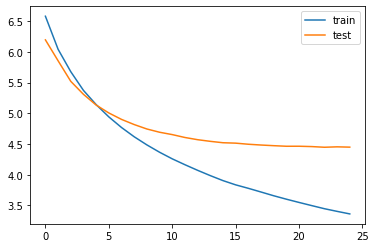

In [102]:
# 훈련데이터의 손실과 검증 데이터의 손실이 줄어드는 과정 시각화 하기
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step 4. 실제 결과와 요약문 비교하기(추상적 요약)

### 인퍼런스 모델 구현하기

In [103]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [104]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [105]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [106]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [107]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [108]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : russia deploy disputed island near japan russian pm dmitry medvedev allowed nation air force use civilian airport island part group four russian occupied islands seized end wwii japan termed russia move attempt increase military power islands 
실제 요약 : russia to deploy on disputed island near japan 
예측 요약 :  russia to ukraine amid russia


원문 : amidst congress claims government winter session finance minister arun jaitley wednesday said parliament would regular session one coincide state assembly elections earlier congress claimed government delaying session avoid discussion issues like demonetisation gst due elections 
실제 요약 : winter session not to clash with state polls 
예측 요약 :  congress is a of congress union minister


원문 : year old patient played guitar undergoing seven hour brain surgery private hospital bengaluru patient suffering musician neurological muscle disorder causing muscle played guitar help doctors target problem area suffered condition playing guitar 
실제 요약 : be

# Step 5. Summa을 이용해서 추출적 요약해보기

#### summarize()의 인자로 사용되는 값
**text (str)** : 요약할 테스트.   

**ratio (float, optional)** – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값    

**words (int or None, optional)** – 출력에 포함할 단어 수.    
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.      

**split (bool, optional)** – True면 문장 list / False는 조인(join)된 문자열을 반환   

In [109]:
import requests
from summa.summarizer import summarize

In [110]:
text_str = data['text'][200]
print(summarize(text_str, ratio=0.5))

Australia's wicketkeeper-batswoman Alyssa Healy has said that the Australian team needs to be wary of India's women's T20I team captain Harmanpreet Kaur at the ICC Women's T20 World Cup next year.


In [111]:
text_str = data['text'][100]
print(summarize(text_str, ratio=0.8))

German multinational engineering and electronics firm Bosch has made its first investment in India in Bengaluru-based deep-tech startup SimYog. SimYog has raised about Ã¢ÂÂ¹6.3 crore in the funding round, with participation from early-stage venture capital firm Ideaspring Capital.


In [112]:
text_str = data['text'][50]
print(summarize(text_str, ratio=0.8))

Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).
This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.


# 🌟 루브릭

|평가문항|상세문항|
|:------|:---|
|1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.|분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.|
|2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.|모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.|
|3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.|두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.|

# 🌟회고

이번 exploration은 사실 개념이나 코드를 깊게 이해하지 못하고 프로젝트를 진행한 점이 아쉽다. \
특히나 Attention 개념은 한번에 이해하지 못해서 노드에 나와있는 내용 외에도 따로 찾아보면서 이해하려고 노력했다. 

[Attention 개념 참고](https://glee1228.tistory.com/3)